# **1. Импортирование необходимых библиотек**

In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from joblib import dump

# **1. Предобработка данных**

Загрузка данных

In [15]:
df = pd.read_excel("data.xlsx")
df

,Date,River level (cm)
0,2014-03-31,28
1,2014-04-01,37
2,2014-04-02,47
3,2014-04-03,60
4,2014-04-04,69
...,...,...
3655,2024-04-07,13
3656,2024-04-08,26
3657,2024-04-09,32
3658,2024-04-10,44


Массив выходных данных

In [16]:
y = df['River level (cm)'].values
y.shape

(3660,)

Даты

In [17]:
date = df['Date'].values
print(f"Length date array: {date.shape[0]}")
print(f"{date[:5]}")

Length date array: 3660
['2014-03-31T00:00:00.000000000' '2014-04-01T00:00:00.000000000'
 '2014-04-02T00:00:00.000000000' '2014-04-03T00:00:00.000000000'
 '2014-04-04T00:00:00.000000000']


Нормализация данных

In [18]:
scaler =  MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

Создание набора последовательностей для LSTM-слоев

In [19]:
def create_sequences(data, seq_length):
    """
    Эта функция создает последовательности указанной длины из заданного массива данных.
    Он используется для подготовки входных данных для нейронных сетей LSTM (Long Short-Term Memory).

    Параметры:
    data (numpy.ndarray): массив входных данных, из которого будут созданы последовательности.
    seq_length (int): длина каждой последовательности.
    
    Возвращает:
    X (numpy.ndarray): трехмерный массив формы (n_samples, seq_length, n_features), где n_samples — количество последовательностей, seq_length — это длина каждой последовательности, а n_features — это количество объектов во входных данных.
    y (numpy.ndarray): одномерный массив формы (n_samples), содержащий целевые значения для каждой последовательности.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

Создание входных признаков и целевых переменных

In [20]:
seq_len = 30  # Длина последовательности
x, y = create_sequences(y_scaled, seq_len)
assert len(x) == len(y)

Разделение дата-сета на:

* тренировочный набор (60% от всего набора)
* набор перекрёстной проверки (20% от всего набора)
* тестовый набор (20% от всего набора)

In [21]:
# Задать пропорции для наборов тренировочного, тестового и кросс-валидации 
train_ratio = 0.6
test_ratio = 0.2
cv_ratio = 0.2

# Вычислить количество примеров для каждого набора
total_samples = len(x)
train_size = int(total_samples * train_ratio)
test_size = int(total_samples * test_ratio)
cv_size = total_samples - train_size - test_size

# Разделить данные
x_train = x[:train_size]
y_train = y[:train_size]

x_cv = x[train_size:train_size + test_size]
y_cv = y[train_size:train_size + test_size]

x_test = x[train_size + test_size:]
y_test = y[train_size + test_size:]

# Печать размеров для проверки
print(f"x Train: {x_train.shape},\ty Train: {y_train.shape}")
print(f"x Test: {x_test.shape},\ty Test: {y_test.shape}")
print(f"x CV : {x_cv.shape},\ty CV: {y_cv.shape}")

# Задать даты для дальнейшего построения графиков
date_test = date[-726:]
print(f"Date Test: {date_test.shape}")

x Train: (2178, 30, 1),	y Train: (2178, 1)
x Test: (726, 30, 1),	y Test: (726, 1)
x CV : (726, 30, 1),	y CV: (726, 1)
Date Test: (726,)


# **2. Поиск подходящей архитектуры модели**

In [22]:
def build_model(hp):
    """
    Эта функция создает модель глубокого обучения для прогнозирования уровня реки с использованием слоев LSTM.
    Архитектура модели определяется с помощью тюнера Hyperband Keras Tuner, который случайным образом ищет лучшие гиперпараметры.

    Параметры:
    hp (HyperParameters): объект, содержащий настраиваемые гиперпараметры..

    Возвращает:
    model (Sequential): скомпилированная модель Keras, готовая к обучению.
    """

    # Инициализируем модель
    model = Sequential()

    # Добавляем слои LSTM со случайно настроенными гиперпараметрами
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(
            LSTM(
                units=hp.Int(
                    f'units_{i}', min_value=32, max_value=512, step=32
                ),
                return_sequences=(i < hp.get('num_layers') - 1)
            )
        )

    # Добавьте полносвязный слой со случайно настроенными гиперпараметрами
    model.add(
        Dense(
            units=hp.Int(
                'dense_units', min_value=32, max_value=512, step=32
            ),
            activation='relu'
        )
    )

    # Добавить выходной слой
    model.add(Dense(1))

    # Скомпилируйте модель с помощью оптимизатора Адама и определите функцию потери средней абсолютной ошибкой
    model.compile(optimizer=Adam(
        learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    ),
        loss='mean_absolute_error'
    )

    return model

Настроить тюнер для оптимизации гиперпараметров. Тюнер использует функцию build_model для создания моделей и оценки их производительности.
Максимальное количество комбинаций гиперпараметров, которые можно попробовать - 50.
Количество раз выполнения каждого испытания (модели) с разными гиперпараметрами - 3.


In [23]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='history_learning',
    project_name='river_level_prediction'
)

Reloading Tuner from history_learning\river_level_prediction\tuner0.json


EarlyStopping используется для остановки обучения, когда отслеживаемый показатель перестает улучшаться. В вашем случае обучение прекратится, если потери при проверке не будут улучшаться в течение 10 последовательных эпох.

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10
)

Поиск гиперпараметров модели

In [28]:
tuner.search(
    x_train, y_train,
    epochs=1000, batch_size=32,
    validation_data=(x_cv, y_cv),
    callbacks=[early_stopping]
)

In [35]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Лучшие гиперпараметры:")
print(best_hyperparameters)

# Получение лучших результатов тестирования
best_trials = tuner.oracle.get_best_trials(num_trials=10)
for trial in best_trials:
    print(f'Trial ID: {trial.trial_id}')
    print(f'Hyperparameters: {trial.hyperparameters.values}')
    print(f'Metrics: {trial.metrics.get_best_value("val_loss")}')
    print()


Лучшие гиперпараметры:
Trial ID: 37
Hyperparameters: {'num_layers': 1, 'units_0': 384, 'dense_units': 416, 'learning_rate': 0.00012596741609878804, 'units_1': 448, 'units_2': 416, 'units_3': 320}
Metrics: 0.004701522178947926

Trial ID: 10
Hyperparameters: {'num_layers': 1, 'units_0': 32, 'dense_units': 32, 'learning_rate': 0.000520348319313704, 'units_1': 96, 'units_2': 448, 'units_3': 416}
Metrics: 0.004836188163608313

Trial ID: 38
Hyperparameters: {'num_layers': 1, 'units_0': 64, 'dense_units': 288, 'learning_rate': 0.0005769877763389441, 'units_1': 320, 'units_2': 160, 'units_3': 224}
Metrics: 0.0048483336965243025

Trial ID: 33
Hyperparameters: {'num_layers': 1, 'units_0': 288, 'dense_units': 224, 'learning_rate': 0.0002588664435216088, 'units_1': 32, 'units_2': 352, 'units_3': 64}
Metrics: 0.004859431957205136

Trial ID: 13
Hyperparameters: {'num_layers': 1, 'units_0': 224, 'dense_units': 224, 'learning_rate': 0.000191223759437469, 'units_1': 384, 'units_2': 384, 'units_3': 160}

# **3. Построение и тестирование модели**

После перекрестной проверки строим модель по лучшим параметрам и тестируем ее на Test set.

In [42]:
# Построение модели.
model = Sequential([
    LSTM(384, return_sequences=False, input_shape=(seq_len, 1)),
    Dense(416, activation='relu'),
    Dense(1)
])

# Компиляция модели.
model.compile(
    optimizer=Adam(0.00012596741609878804),
    loss='mean_absolute_error'
)

# Настройка для ранней остановки обучения.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Обучение модели.
model.fit(
    x_train, y_train,
    epochs=1000,
    validation_data=(x_cv, y_cv),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

D:\Projects\WaterLevelAI\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - loss: 0.1575 - val_loss: 0.0400
Epoch 2/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 0.0322 - val_loss: 0.0270
Epoch 3/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 4/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 0.0223 - val_loss: 0.0246
Epoch 5/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 6/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 0.0174 - val_loss: 0.0237
Epoch 7/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0176 - val_loss: 0.0151
Epoch 8/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.0144 - val_loss: 0.0173
Epoch 9/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0151 - val_loss: 0.0132
Epoch 10/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.0145 - val_loss: 0.0122
Epoch 11/1000
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0141 - val_loss: 0.0125
Epoch 12/1000
69/69

Предсказание и оценка модели по метрике MAE.

In [52]:
# Предсказание модели.
pred = model.predict(x_test)

# Обратное масштабирование предсказанных значений.
pred_rescaled = scaler.inverse_transform(pred)

# Обратное масштабирование тестовых (фактических) значений.
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Оценка модели
mae = mean_absolute_error(y_test_rescaled, pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, pred_rescaled) / 2)

print(f"MAE's Value: {mae:.2f}")
print(f"RMSE's Value: {rmse:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
MAE Value: 5.69
RMSE Value: 11.48


Построение графика фактических и предсказанных значений

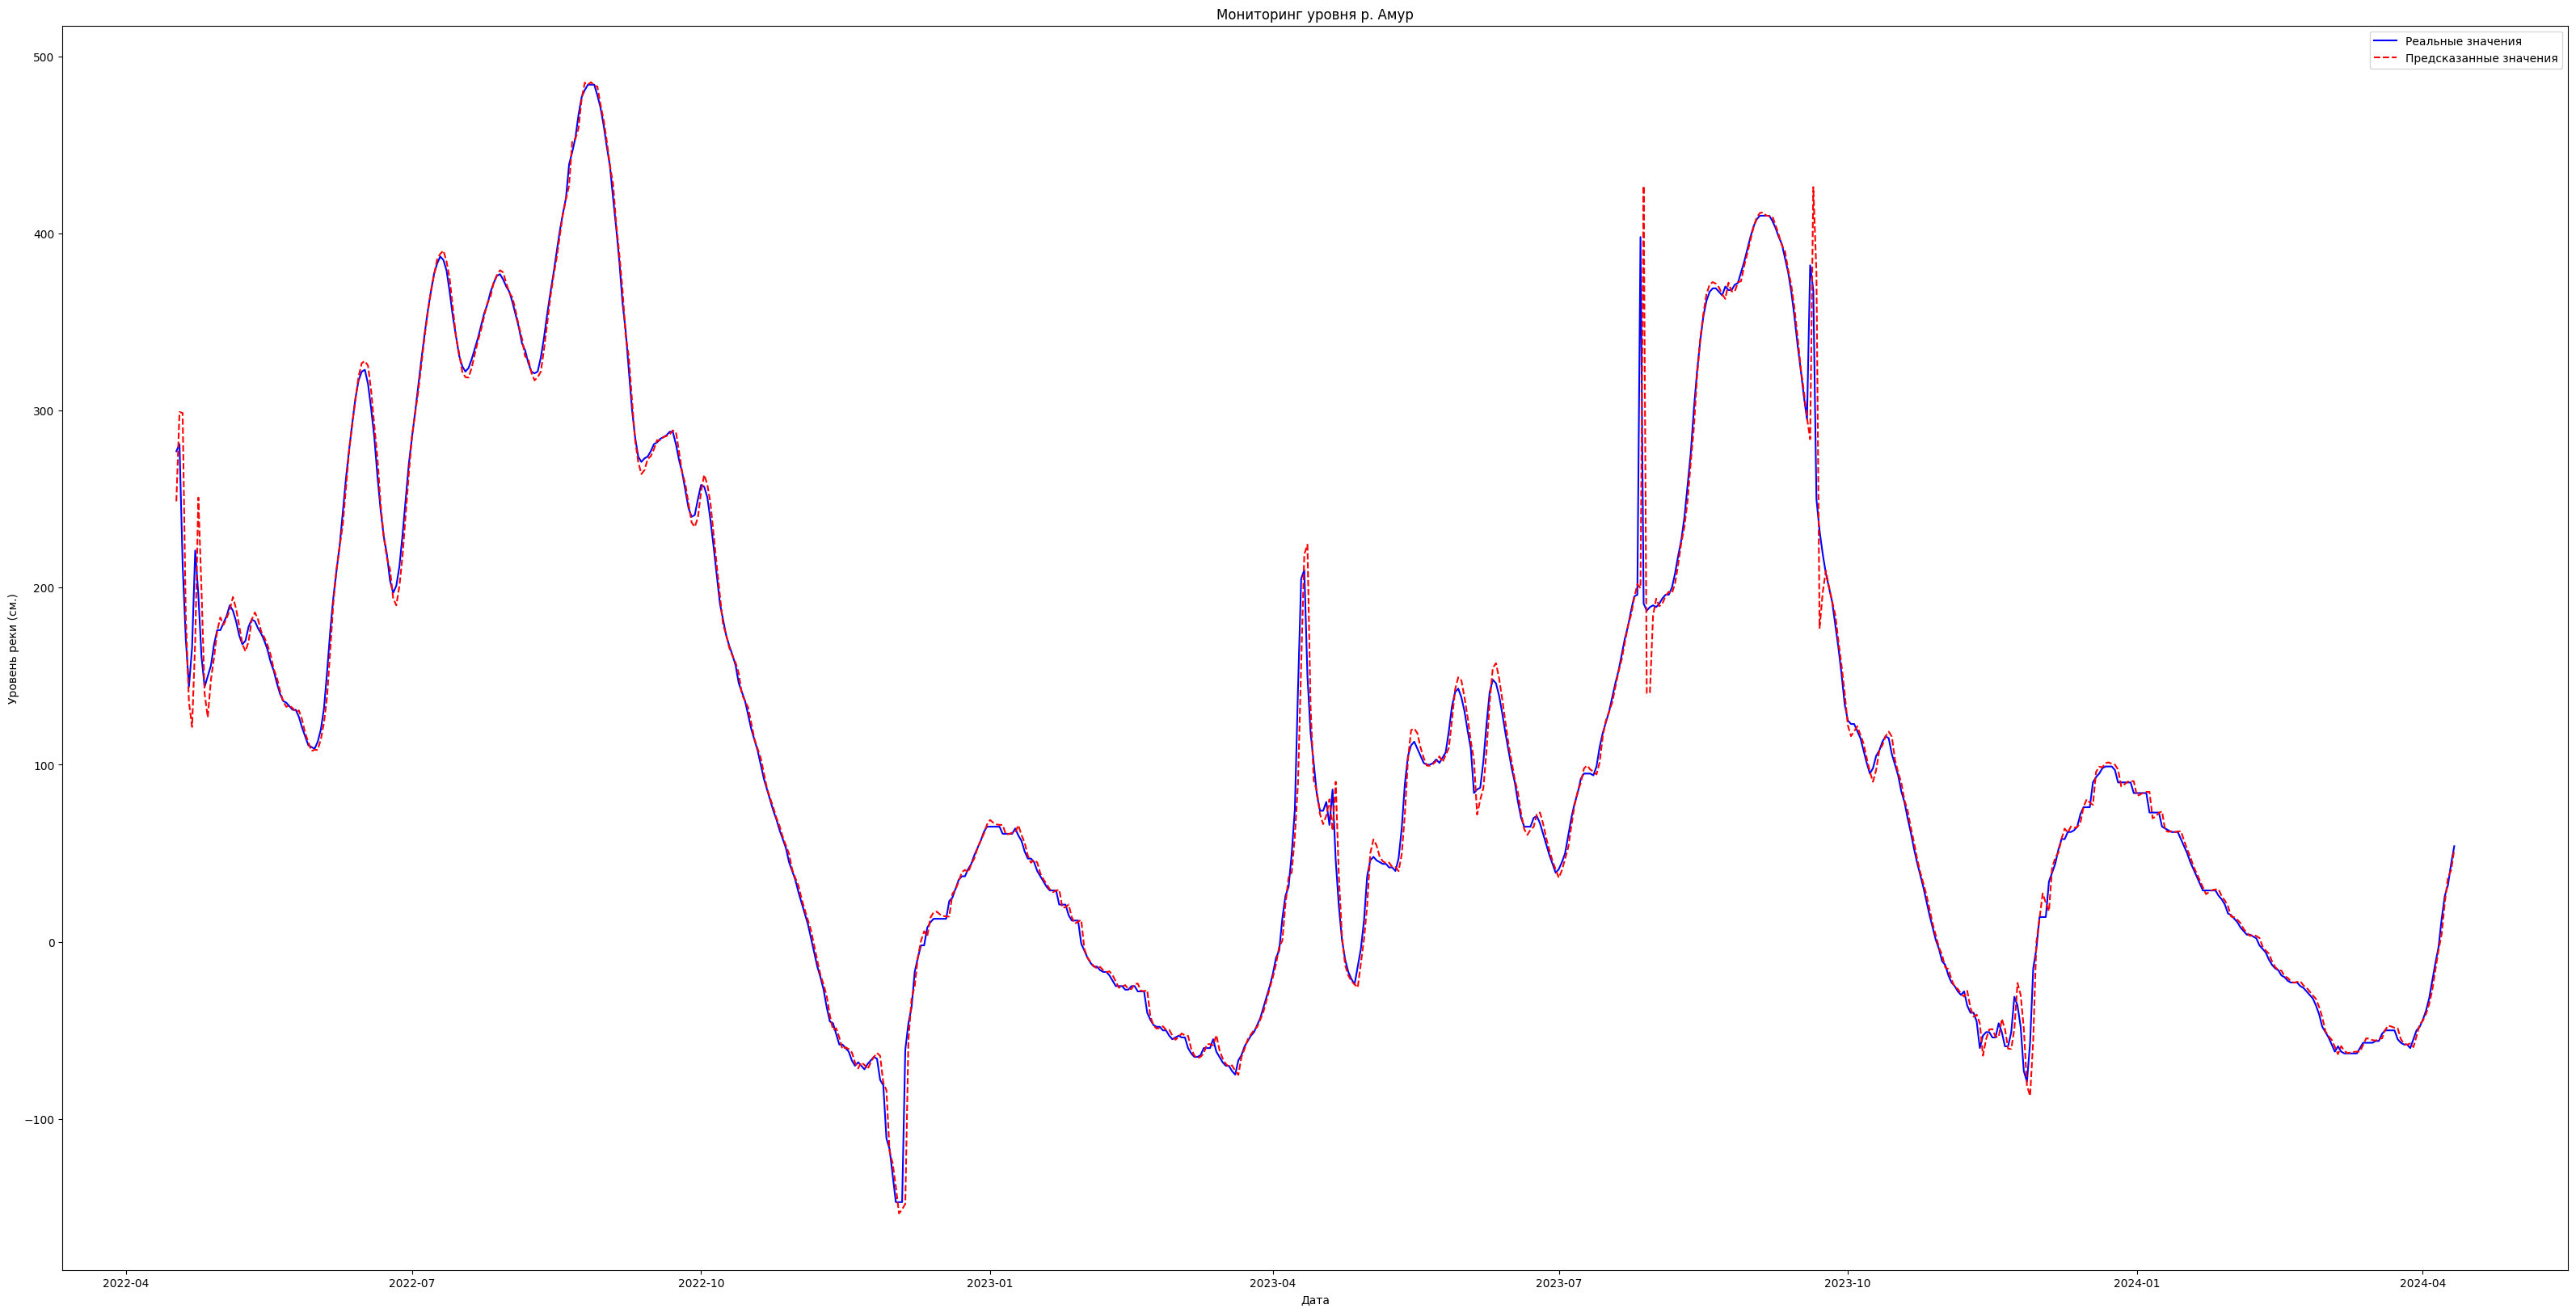

In [47]:
plt.figure(figsize=(40, 20))
plt.plot(date_test, y_test_rescaled, color='blue', label='Реальные значения')
plt.plot(date_test, pred_rescaled, color='red', linestyle='--', label='Предсказанные значения')
plt.title('Мониторинг уровня р. Амур')
plt.xlabel('Дата')
plt.ylabel('Уровень реки (см.)')
plt.legend()
plt.show()

# **4. Сохранить и скачать модель**

In [57]:
model.save('river_monitoring_model.keras')
dump(scaler, 'scaler.joblib')

['scaler.joblib']